# Import supporting package

In [30]:
import xarray as xr
import pandas as pd
import numpy as np
import copy

import glob

import xrft
import finufft

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

from datetime import datetime

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FFTAnalyser import fft, ifft, fft_nutou
from ToolFunction.ToolFunction import *

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()

## Start a client for parallel computing

In [5]:
from dask.distributed import Client
client = Client(n_workers=6, threads_per_worker=10, processes=True, memory_limit='10GB')
client

<Client: 'tcp://127.0.0.1:61152' processes=6 threads=60, memory=55.88 GiB>

## Set global path for experiment

In [6]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    "images/ODT_1_Axis_Camera/in_situ_absorption",
    "images/ODT_2_Axis_Camera/in_situ_absorption",
]

dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_0",
    "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_1",
    "images/ODT_2_Axis_Camera/in_situ_absorption": "camera_2",
}


In [7]:
img_dir = '//DyLabNAS/Data/'
SequenceName = "Evaporative_Cooling" + "/"
folderPath = img_dir + SequenceName + "2023/05/09" # get_date()

# Read CSV

In [47]:
filePath = 'Z:/Dy_Lab/Data/Measurements/Experiments/DyBEC/BEC Stability Check/20230509-0007/*.csv'

filePath = np.sort(glob.glob(filePath))

data = np.empty(filePath.shape,dtype=object)

i = 0
for fp in filePath:
    data_single = pd.read_csv(fp)
    data_single = xr.Dataset.from_dataframe(data_single)
    data_single = data_single.drop_isel(index=0)
    data_single = data_single.expand_dims(dim='runs')
    data[i] = data_single
    i = i + 1

xr.combine_nested(data, concat_dim=['runs'])

# data.assign_coords(dict(index=data.Time))

# data = xr.Dataset(
#     data_vars = {
#         'arm1': data['Channel C'],
#         'arm2': data['Channel A'],
#     },
#     coords = {
#         'index': data['Time']
#     }
# )

# data = data.rename(dict(index='time'))

ValueError: concat_dims has length 1 but the datasets passed are nested in a 0-dimensional structure

In [48]:
data[0]

<xarray.Dataset>
Dimensions:    (index: 100004, runs: 1)
Coordinates:
  * index      (index) int64 1 2 3 4 5 6 ... 100000 100001 100002 100003 100004
Dimensions without coordinates: runs
Data variables:
    Time       (runs, index) object '-0.44999999' '-0.44994999' ... '4.55014989'
    Channel A  (runs, index) object '-0.02044740' '-0.03051851' ... '0.09063997'
    Channel C  (runs, index) object '-0.01525925' '-0.01525925' ... '0.05981628'

In [61]:
xr.combine_nested(data[0:2], concat_dim=[['runs']])

ValueError: concat_dims has length 1 but the datasets passed are nested in a 0-dimensional structure

# Read data

## Set file path

In [3]:
# filepath = "//DyLabNAS/Data/Evaporative_Cooling/2023/05/03/0043/*.h5"
# filepath = "//DyLabNAS/Data/Evaporative_Cooling/2023/04/18/0003/2023-04-18_0003_Evaporative_Cooling_000.h5"

# filepath = "//DyLabNAS/Data/Repetition_scan/2023/04/21/0002/*.h5"

filepath = r"./testData/0002/*.h5"

# filepath = r"./testData/0002/2023-04-21_0002_Evaporative_Cooling_0.h5"

# filepath = r'd:/Jianshun Gao/Simulations/analyseScripts/testData/0002/2023-04-21_0002_Evaporative_Cooling_0.h5'

# filepath = "//DyLabNAS/Data/Evaporative_Cooling/2023/04/18/0003/*.h5"

# filepath = "//DyLabNAS/Data/Evaporative_Cooling/2023/05/04/0000/*.h5"

In [4]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    # "images/ODT_1_Axis_Camera/in_situ_absorption",
]

dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_1",
    # "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_2",
}

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filepath, groupList[i])
    for i in range(len(groupList))
}

## Rechunk the data for parallel computing

In [5]:
dataSet = dataSetDict["camera_1"]

scanAxis = dataSet.scanAxis

# dataSet = dataSet.chunk(
#     {
#         # "compZ_current_sg": "auto",
#         "sin_mod_freq": "auto",
#         "runs": 2,
#         "x": "auto",
#         "y": "auto",
#     }
# )

# Calculate absorption imaging

## get OD images

In [6]:
dataSet = imageAnalyser.get_absorption_images(dataSet)

dataSet

<xarray.Dataset>
Dimensions:     (runs: 3, x: 1200, y: 1920)
Coordinates:
  * runs        (runs) float64 0.0 1.0 2.0
Dimensions without coordinates: x, y
Data variables:
    atoms       (runs, x, y) uint16 dask.array<chunksize=(1, 1200, 1920), meta=np.ndarray>
    background  (runs, x, y) uint16 dask.array<chunksize=(1, 1200, 1920), meta=np.ndarray>
    dark        (runs, x, y) uint16 dask.array<chunksize=(1, 1200, 1920), meta=np.ndarray>
    shotNum     (runs) int64 0 1 2
    OD          (runs, x, y) float64 dask.array<chunksize=(1, 1200, 1920), meta=np.ndarray>
Attributes: (12/96)
    TOF_free:                          0.02
    abs_img_freq:                      110.858
    absorption_imaging_flag:           True
    backup_data:                       True
    blink_off_time:                    nan
    blink_on_time:                     nan
    ...                                ...
    y_offset_img:                      0
    z_offset:                          0.189
    z_offset_img:                      0.189
    runs:                              [0. 1. 2.]
    scanAxis:                          ['runs']
    scanAxisLength:                    [3.]

## Select region of interests

In [9]:
# imageAnalyser.center = (529, 962)
# imageAnalyser.span = (100,100)
# imageAnalyser.fraction = (0.1, 0.1)

# imageAnalyser.center = (890, 1150)
# imageAnalyser.span = (600,600)
# imageAnalyser.fraction = (0.1, 0.1)

imageAnalyser.center = (890, 950)
imageAnalyser.span = (100,100)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_crop = imageAnalyser.crop_image(dataSet)

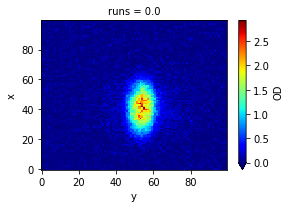

In [10]:
dataSet_crop.OD.isel(runs=[0]).plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])
# dataSet_crop.OD.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0])

## Remove the background

In [ ]:
dataSet_crop['OD'] = dataSet_crop['OD'] + 500

In [ ]:
dataSet_crop['OD'] = imageAnalyser.substract_offset(dataSet_crop['OD'])

# Test Fit

In [ ]:
fitAnalyser = FitAnalyser("Two Gaussian-2D", fitDim=2)

params = fitAnalyser.guess(dataSet_crop.OD, dask="parallelized")

In [ ]:
fitResult = fitAnalyser.fit(dataSet_crop.OD, params).load()

In [ ]:
fitCurve = fitAnalyser.eval(fitResult, x=np.arange(100), y=np.arange(100), dask="parallelized").load()

In [ ]:
# fitCurve.isel(**{scanAxis[0]:np.arange(30), 'runs':range(dataSet_crop.OD['runs'].size)}).plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])

fitCurve.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0])

In [ ]:
a = fitAnalyser.get_fit_value(fitResult)
b = fitAnalyser.get_fit_std(fitResult)
data = combine_uncertainty(a, b)

# Get the Ncount

In [ ]:
Ncount = dataSet_crop.OD.sum(dim=(scanAxis[0], 'x', 'y'))

In [ ]:
Ncount.load()

fig = plt.figure()
ax = fig.gca()
Ncount.plot(ax=ax)

In [ ]:
fitAnalyser = FitAnalyser("Lorentzian With Offset")
params = fitAnalyser.guess(Ncount, x='sin_mod_freq', dask="parallelized", guess_kwargs=dict(negative=True))

In [ ]:
fitResult = fitAnalyser.fit(Ncount, params, x='sin_mod_freq', dask="parallelized")
fitCurve = fitAnalyser.eval(fitResult, x=np.arange(40), dask="parallelized").load()

In [ ]:
fig = plt.figure()
ax = fig.gca()
plt.errorbar([1], [1], yerr=[1])

In [ ]:
fitCurve.plot.errorbar(yerr=fitCurve)

In [ ]:
np.ufunc(fitCurve)